# Planning a Radar Tracking Mission for a Research UAV

## Part I. Mission Build: Designing the Tracking Filter

### 1. Trajectory Generation in the Cartesian Coordinate System
Generate the true trajectory of a UAV moving uniformly. The motion is deterministic, with no random disturbances.

**Initial Conditions:**
- Trajectory size `N = 26` points.
- Time interval `T = 2` seconds.
- Initial velocities `Vx = -50` m/s, `Vy = -45` m/s.
- Initial coordinates for the "Far-Range Approach": `x0 = 13500/√2`, `y0 = 13500/√2`.

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def generate_trajectory(x0, y0, vx, vy, T, N):
    x_true = np.zeros(N)
    y_true = np.zeros(N)
    vx_true = np.full(N, vx)
    vy_true = np.full(N, vy)

    x_true[0] = x0
    y_true[0] = y0

    for i in range(1, N):
        x_true[i] = x_true[i-1] + vx_true[i-1] * T
        y_true[i] = y_true[i-1] + vy_true[i-1] * T
    
    return x_true, y_true, vx_true, vy_true

N = 26
T = 2.0 
vx_initial = -50.0
vy_initial = -45.0
x0 = 13500 / np.sqrt(2)
y0 = 13500 / np.sqrt(2)

x_true, y_true, _, _ = generate_trajectory(x0, y0, vx_initial, vy_initial, T, N)

### 2. Generation of True Range D and Azimuth β
Convert the true Cartesian coordinates `(x, y)` into true polar coordinates, range `D` and azimuth `β`. The azimuth `β` is calculated as `arctan(x/y)`, which implies it is the angle measured from the Y-axis.

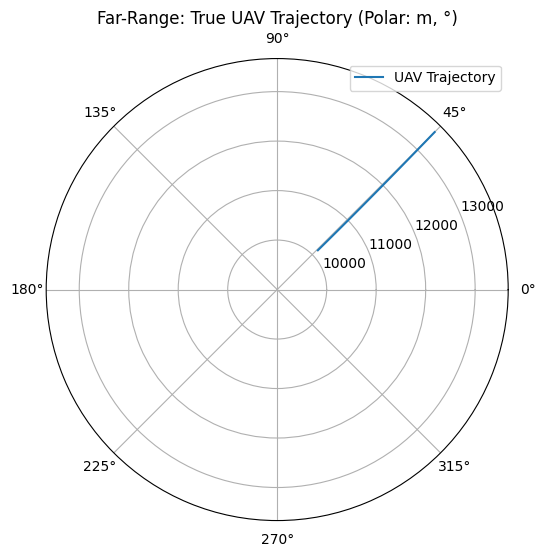

In [88]:
def to_polar(x, y):
    D = np.sqrt(x**2 + y**2)
    beta = np.arctan2(x, y)
    return D, beta

D_true, beta_true = to_polar(x_true, y_true)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(polar=True)
ax.plot(beta_true, D_true, label='UAV Trajectory')
ax.set_title('Far-Range: True UAV Trajectory (Polar: m, °)')
ax.set_rmin(9000)
ax.legend()
plt.show()

### 3. Measurement Generation
Simulate radar measurements by adding Gaussian noise to the true range and azimuth values. 

**Noise Variances:**
- `sigma_D = 20` m
- `sigma_β = 0.02` rad

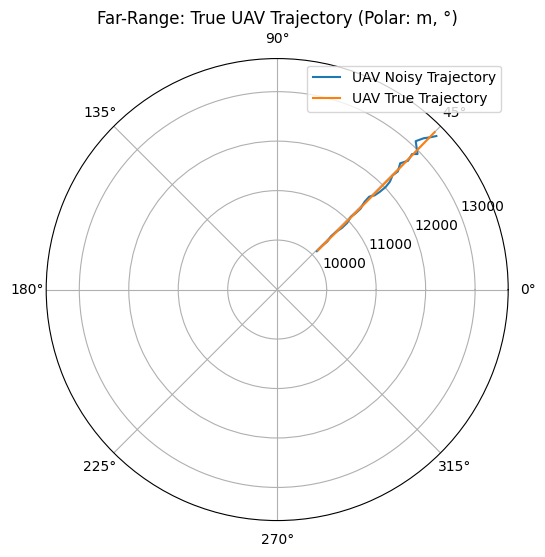

In [89]:
def generate_measurements(D_true, beta_true, sigma_D, sigma_beta, N):
    noise_D = np.random.normal(0, sigma_D, N)
    D_m = D_true + noise_D

    noise_beta = np.random.normal(0, sigma_beta, N)
    beta_m = beta_true + noise_beta
    return D_m, beta_m

sigma_D = 20.0
sigma_beta = 0.02

D_m, beta_m = generate_measurements(D_true, beta_true, sigma_D, sigma_beta, N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(polar=True)
ax.plot(beta_m, D_m, label='UAV Noisy Trajectory')
ax.plot(beta_true, D_true, label='UAV True Trajectory')
ax.set_title('Far-Range: True UAV Trajectory (Polar: m, °)')
ax.legend()
ax.set_rmin(9000)
plt.show()

### 4. Pseudo-measurements
Transform the noisy polar measurements back into Cartesian coordinates. These are called "pseudo-measurements" because they are derived from the actual measurements and will be used as the input for our Cartesian-based Kalman filter.

In [90]:
def to_cartesian(D, beta):
    x = D * np.sin(beta)
    y = D * np.cos(beta)
    return x, y

x_pseudo, y_pseudo = to_cartesian(D_m, beta_m)

### 5. Measurement Vector

In [91]:
z = np.array([x_pseudo, y_pseudo]).T

### 6. Initial Conditions for the Kalman Filter Algorithm

In [92]:
X0_0 = np.array([[40000], [-20], [40000], [-20]])

P0_0 = np.diag([1e10, 1e10, 1e10, 1e10])

### 7. Create the Transition Matrix Φ and the Observation Matrix H

In [93]:
Phi = np.array([
    [1, T, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, T],
    [0, 0, 0, 1]
])

H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

### 8. Create the Measurement Error Covariance Matrix R
The covariance matrix `R` is derived by transforming the covariance of the polar measurement noise into Cartesian coordinates using a Jacobian matrix. Since `R` depends on the true range and azimuth, which are unknown, calculate it at each step using the predicted state from the filter.

In [94]:
def calculate_R(D, beta, sigma_D, sigma_beta):
    s_beta, c_beta = np.sin(beta), np.cos(beta)
    sigma_D_sq = sigma_D**2
    sigma_beta_sq = sigma_beta**2

    r11 = s_beta**2 * sigma_D_sq + (D**2 * c_beta**2) * sigma_beta_sq
    r12 = s_beta * c_beta * sigma_D_sq - (D**2 * s_beta * c_beta) * sigma_beta_sq
    r22 = c_beta**2 * sigma_D_sq + (D**2 * s_beta**2) * sigma_beta_sq

    R = np.array([[r11, r12], [r12, r22]])
    return R

### 9. Develop the Kalman Filter Algorithm
Here we implement the Kalman filter. The function will perform the prediction and filtration steps for each measurement. As the true motion is deterministic, the process noise matrix `Q` is set to zero.

In [95]:
def run_kalman_filter(z, N, Phi, H, X0_0, P0_0, sigma_D, sigma_beta):
    X_filt_prev = X0_0
    P_filt_prev = P0_0

    X_predicted = np.zeros((N, 4, 1))
    P_predicted = np.zeros((N, 4, 4))
    X_filtered = np.zeros((N, 4, 1))
    P_filtered = np.zeros((N, 4, 4))
    K_history = np.zeros((N, 4, 2))
    R_history = np.zeros((N, 2, 2))

    Q = np.zeros((4, 4))
    I = np.eye(4)

    for i in range(N):
        X_pred = Phi @ X_filt_prev
        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        x_p, y_p = X_pred[0, 0], X_pred[2, 0]
        D_p, beta_p = to_polar(x_p, y_p)
        Ri = calculate_R(D_p, beta_p, sigma_D, sigma_beta)
        
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + Ri)

        residual = z[i].reshape(2,1) - H @ X_pred
        X_filt = X_pred + K @ residual
        P_filt = (I - K @ H) @ P_pred

        X_predicted[i], P_predicted[i] = X_pred, P_pred
        X_filtered[i], P_filtered[i] = X_filt, P_filt
        K_history[i] = K
        R_history[i] = Ri
            
        X_filt_prev, P_filt_prev = X_filt, P_filt
    
    return X_filtered, P_filtered, X_predicted, P_predicted, K_history, R_history

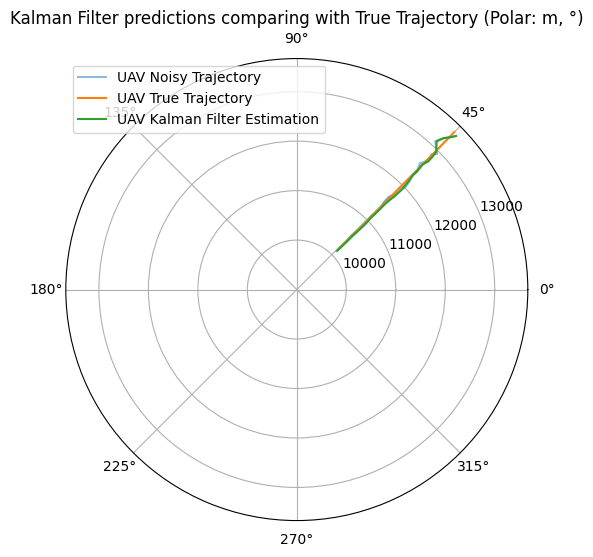

In [96]:
X_f, _, _, _, _, _ = run_kalman_filter(z, N, Phi, H, X0_0, P0_0, sigma_D, sigma_beta)

D_filt, beta_filt = to_polar(X_f[:, 0, 0], X_f[:, 2, 0])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(polar=True)
ax.plot(beta_m, D_m, alpha=0.5, label='UAV Noisy Trajectory')
ax.plot(beta_true, D_true, label='UAV True Trajectory')
ax.plot(beta_filt, D_filt, label='UAV Kalman Filter Estimation')
ax.set_title('Kalman Filter predictions comparing with True Trajectory (Polar: m, °)')
ax.legend()
ax.set_rmin(9000)
plt.show()

## Part II. Mission Check: Stress-Testing the Filter
Analyze the filter's performance, use simulations with `M=500` iterations to get statistically meaningful results for the estimation errors.

### Helper Function for Monte Carlo Simulation

In [97]:
def calculate_errors(M, D_true, beta_true, x_true, y_true, N, Phi, H, X0_0, P0_0, sigma_D, sigma_beta):
    err_D_pred_sq = np.zeros((M, N))
    err_D_filt_sq = np.zeros((M, N))
    err_beta_pred_sq = np.zeros((M, N))
    err_beta_filt_sq = np.zeros((M, N))

    for m in range(M):
        D_m, beta_m = generate_measurements(D_true, beta_true, sigma_D, sigma_beta, N)
        x_pseudo, y_pseudo = to_cartesian(D_m, beta_m)
        z = np.array([x_pseudo, y_pseudo]).T

        X_f, _, X_p, _, _, _ = run_kalman_filter(z, N, Phi, H, X0_0, P0_0, sigma_D, sigma_beta)

        D_pred, beta_pred = to_polar(X_p[:, 0, 0], X_p[:, 2, 0])
        D_filt, beta_filt = to_polar(X_f[:, 0, 0], X_f[:, 2, 0])

        err_D_pred_sq[m, :] = (D_pred - D_true)**2
        err_D_filt_sq[m, :] = (D_filt - D_true)**2
        err_beta_pred_sq[m, :] = (beta_pred - beta_true)**2
        err_beta_filt_sq[m, :] = (beta_filt - beta_true)**2

    rmse_D_pred = np.sqrt(np.mean(err_D_pred_sq, axis=0))
    rmse_D_filt = np.sqrt(np.mean(err_D_filt_sq, axis=0))
    rmse_beta_pred = np.sqrt(np.mean(err_beta_pred_sq, axis=0))
    rmse_beta_filt = np.sqrt(np.mean(err_beta_filt_sq, axis=0))

    return rmse_D_pred, rmse_D_filt, rmse_beta_pred, rmse_beta_filt

### 1. Run Kalman filter and Calculate Estimation Errors (Far-Range)
Run `M=500` iterations and calculate the Root Mean Squared Error (RMSE) for range (D) and azimuth (β), normalize these errors by their respective measurement noise standard deviations (`sigma_D` and `sigma_β`). A relative error less than one indicates that the filter is effective at reducing noise.

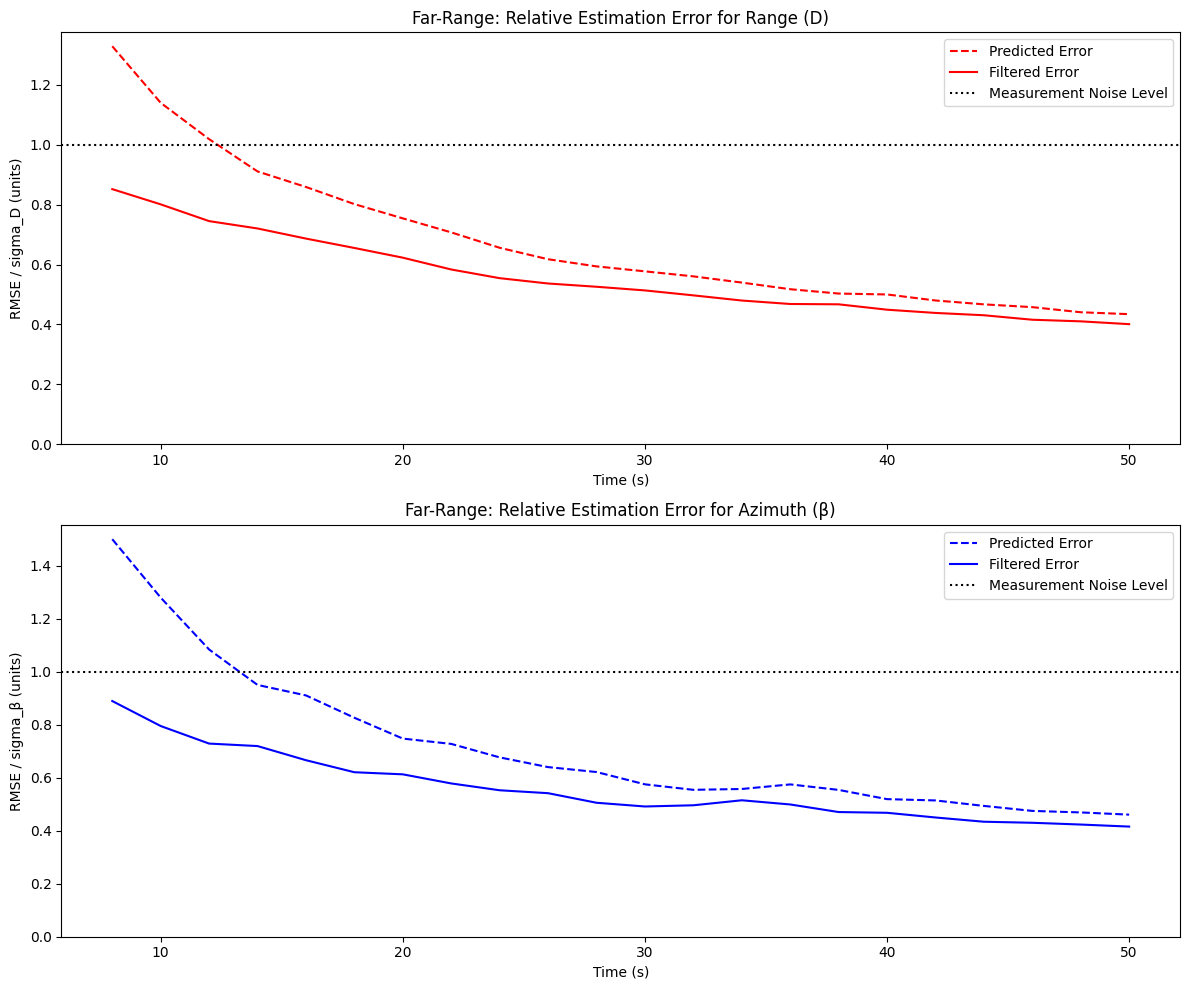

In [98]:
M = 500
rmse_D_p, rmse_D_f, rmse_b_p, rmse_b_f = calculate_errors(M, D_true, beta_true, x_true, y_true, N, Phi, H, X0_0, P0_0, sigma_D, sigma_beta)

time = np.arange(N) * T
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(time[4:], rmse_D_p[4:] / sigma_D, 'r--', label='Predicted Error')
ax1.plot(time[4:], rmse_D_f[4:] / sigma_D, 'r-', label='Filtered Error')
ax1.set_title('Far-Range: Relative Estimation Error for Range (D)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('RMSE / sigma_D (units)')
ax1.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax1.legend()
ax1.set_ylim(bottom=0)

ax2.plot(time[4:], rmse_b_p[4:] / sigma_beta, 'b--', label='Predicted Error')
ax2.plot(time[4:], rmse_b_f[4:] / sigma_beta, 'b-', label='Filtered Error')
ax2.set_title('Far-Range: Relative Estimation Error for Azimuth (β)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('RMSE / sigma_β (units)')
ax2.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax2.legend()
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

After an initial convergence period, the filter becomes effective. The filtered errors for both range and azimuth drop below the measurement noise level (error < 1), indicating successful noise reduction. The errors gradually decrease over time.

### 2. Analyze the Dependence of `x` on `β` (Far-Range)

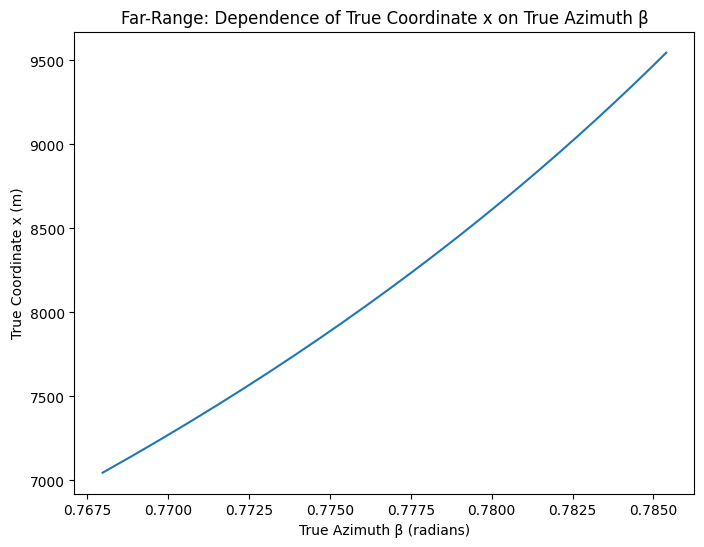

In [99]:
plt.figure(figsize=(8, 6))
plt.plot(beta_true, x_true)
plt.title('Far-Range: Dependence of True Coordinate x on True Azimuth β')
plt.xlabel('True Azimuth β (radians)')
plt.ylabel('True Coordinate x (m)')
plt.show()

For the far-range scenario, the change in azimuth (β) is small. Over this limited range, the relationship between x and β appears to be nearly linear. This suggests that the linearization errors introduced when calculating the covariance matrix R will be insignificant.

### 3. Calculate the Condition Number of R (Far-Range)
The condition number of the covariance matrix `R` tells us about its stability. A number close to 1 indicates a well-conditioned matrix, while a large number indicates an ill-conditioned form, which can amplify errors.

- $λ_1 = σ_D^2$
- $λ_2 = D_{im}^2σ_β^2$

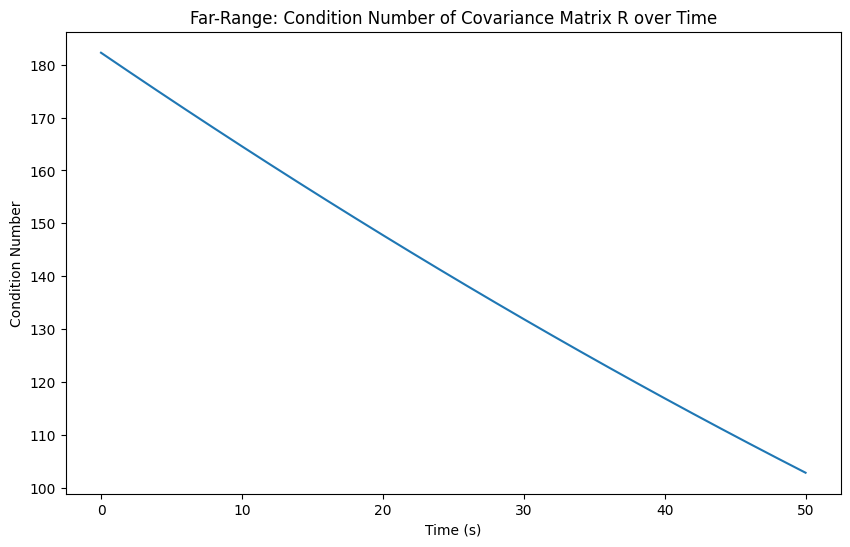

In [122]:
cond_numbers = []
for i in range(N):
    R_i = calculate_R(D_true[i], beta_true[i], sigma_D, sigma_beta)
    cond_numbers.append(np.linalg.cond(R_i))

plt.figure(figsize=(10, 6))
plt.plot(time, cond_numbers)
plt.title('Far-Range: Condition Number of Covariance Matrix R over Time')
plt.xlabel('Time (s)')
plt.ylabel('Condition Number')
plt.show()


The condition number decreases as the UAV moves. The values not big throughout the trajectory, indicating that the matrix R is well-conditioned.

### 4. Analyze the Filter Gain K (Far-Range)
Plot the first element of the Kalman gain matrix, `K(1,1)`, which relates the innovation in the `x` pseudo-measurement to the update of the `x` state estimate. The gain determines how much the filter trusts the new measurement versus its own prediction.

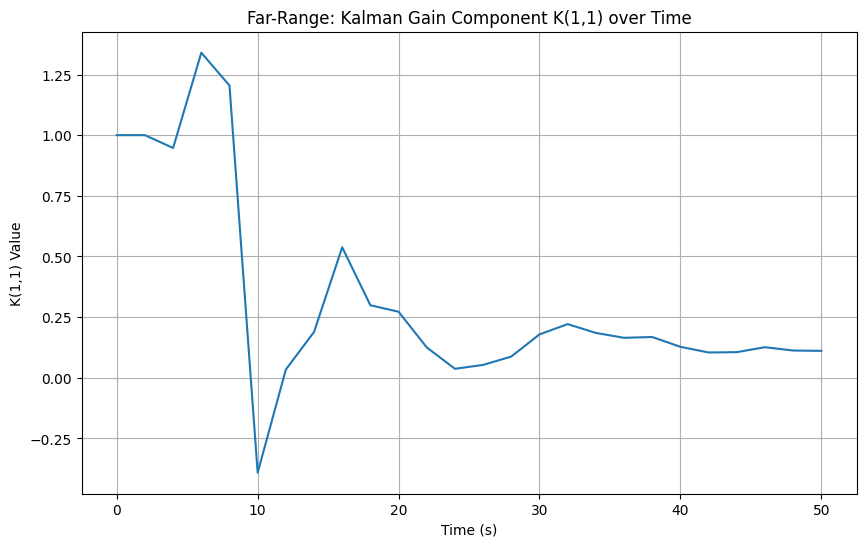

In [101]:
z_single = np.array([x_pseudo, y_pseudo]).T
_, _, _, _, K_hist, _ = run_kalman_filter(z_single, N, Phi, H, X0_0, P0_0, sigma_D, sigma_beta)

plt.figure(figsize=(10, 6))
plt.plot(time, K_hist[:, 0, 0])
plt.title('Far-Range: Kalman Gain Component K(1,1) over Time')
plt.xlabel('Time (s)')
plt.ylabel('K(1,1) Value')
plt.grid()
plt.show()

The gain starts high, indicating that the filter initially relies heavily on the measurements due to high uncertainty in its state estimate (big P). As the filter converges and P decreases, the gain also decreases, showing that the filter starts to trust its own predictions more. The gain remains well within a stable range.

### 5. New Initial Conditions (Close-Range)
We now simulate a scenario where the UAV starts much closer to the observer.
- New initial coordinates: `x0 = 3500/√2`, `y0 = 3500/√2`.

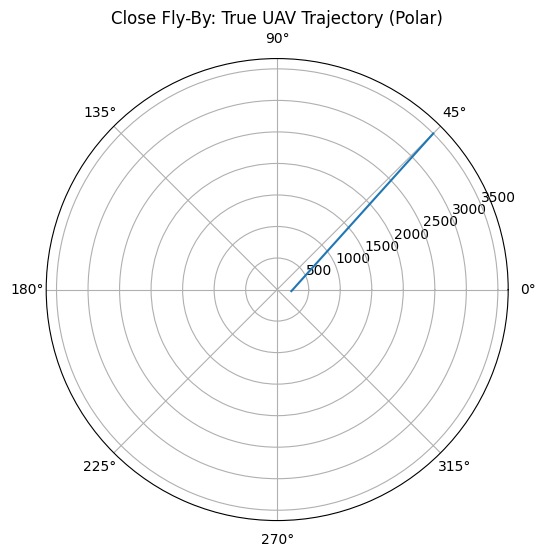

In [102]:
x0_close = 3500 / np.sqrt(2)
y0_close = 3500 / np.sqrt(2)

x_true_close, y_true_close, _, _ = generate_trajectory(x0_close, y0_close, vx_initial, vy_initial, T, N)
D_true_close, beta_true_close = to_polar(x_true_close, y_true_close)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)
ax.plot(beta_true_close, D_true_close)
ax.set_title('Close Fly-By: True UAV Trajectory (Polar)')
plt.show()

### 6. Calculate Estimation Errors (Close-Range)
Preform error analysis for the close-range trajectory, using the same standard noise parameters (`sigma_D=20`, `sigma_β=0.02`).

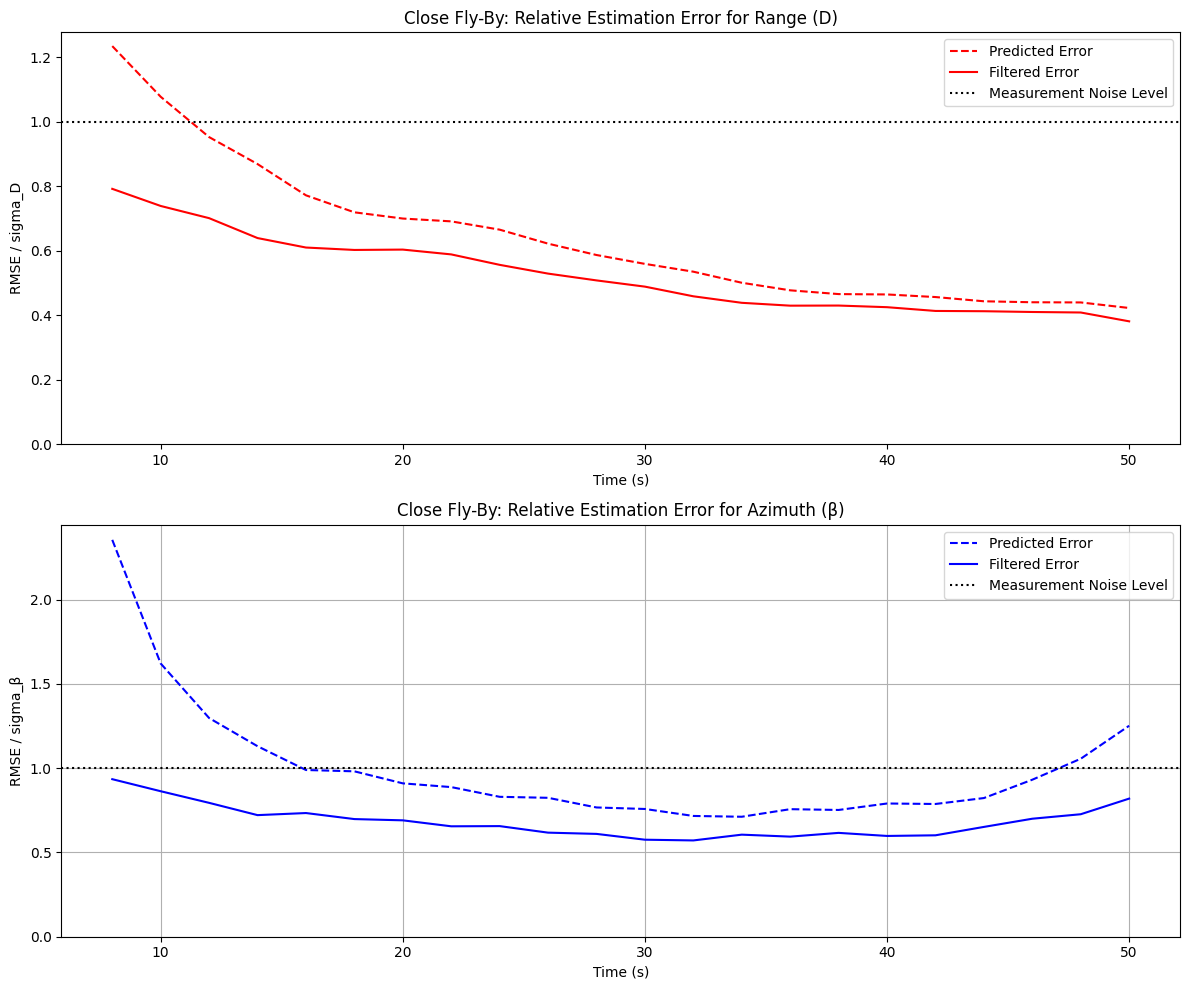

In [124]:
rmse_D_p_close, rmse_D_f_close, rmse_b_p_close, rmse_b_f_close = calculate_errors(
    M, D_true_close, beta_true_close, x_true_close, y_true_close, N, Phi, H, X0_0, P0_0, sigma_D, sigma_beta
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(time[4:], rmse_D_p_close[4:] / sigma_D, 'r--', label='Predicted Error')
ax1.plot(time[4:], rmse_D_f_close[4:] / sigma_D, 'r-', label='Filtered Error')
ax1.set_title('Close Fly-By: Relative Estimation Error for Range (D)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('RMSE / sigma_D')
ax1.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax1.legend()
ax1.set_ylim(bottom=0)

ax2.plot(time[4:], rmse_b_p_close[4:] / sigma_beta, 'b--', label='Predicted Error')
ax2.plot(time[4:], rmse_b_f_close[4:] / sigma_beta, 'b-', label='Filtered Error')
ax2.set_title('Close Fly-By: Relative Estimation Error for Azimuth (β)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('RMSE / sigma_β')
ax2.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax2.legend()
ax2.set_ylim(bottom=0)

plt.grid()
plt.tight_layout()
plt.show()

The filter still performs normal, with filtered errors remaining below the noise level after convergence. However, there's a noticeable increase in the azimuth error around the point of closest approach.

### 7. Analyze the Dependence of `x` on `β` (Close-Range)

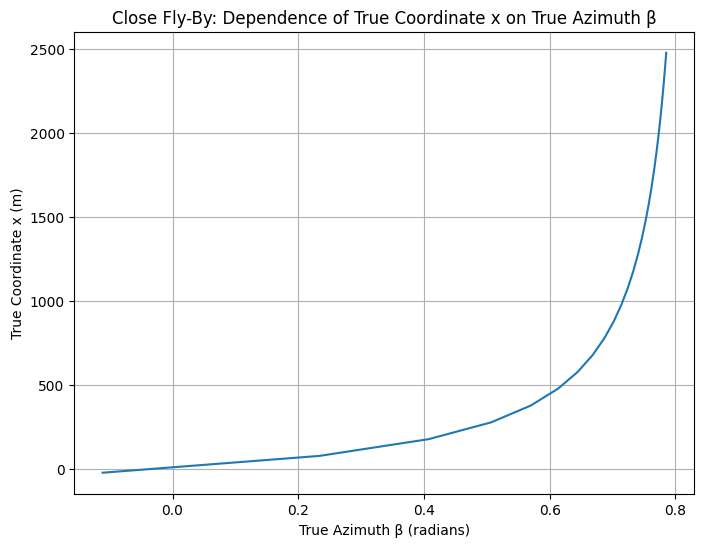

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(beta_true_close, x_true_close)
plt.title('Close Fly-By: Dependence of True Coordinate x on True Azimuth β')
plt.xlabel('True Azimuth β (radians)')
plt.ylabel('True Coordinate x (m)')
plt.grid()
plt.show()

In the close fly-by scenario, the azimuth angle β sweeps through a much larger range. The relationship between x and β is now clearly non-linear. This means that the linearization used to calculate the covariance matrix R is a poorer approximation, and the resulting linearization errors are likely to be significant, impacting the filter's accuracy.

### 8. Calculate the Condition Number of R (Close-Range)

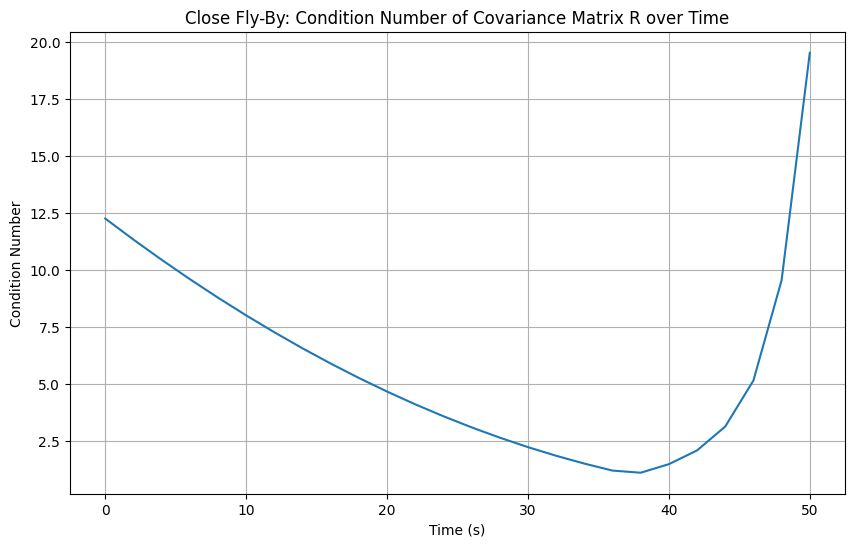

In [105]:
cond_numbers_close = []
for i in range(N):
    R_i = calculate_R(D_true_close[i], beta_true_close[i], sigma_D, sigma_beta)
    cond_numbers_close.append(np.linalg.cond(R_i))

plt.figure(figsize=(10, 6))
plt.plot(time, cond_numbers_close)
plt.title('Close Fly-By: Condition Number of Covariance Matrix R over Time')
plt.xlabel('Time (s)')
plt.ylabel('Condition Number')
plt.grid()
plt.show()

The condition number is lower than in the far-range case, but increases dramatically as the UAV gets closer to the observer. This indicates that the coordinate transformation becomes ill-conditioned at close range. The filter's performance is expected to degrade because small errors in polar measurements can be amplified into large errors in Cartesian pseudo-measurements.

### 9. Conclusions on Linearization and Starting Position

1. When the UAV performs a close fly-by, the change in azimuth is large, making the non-linear relationship between polar and Cartesian coordinates much more complicated. This violates the assumptions of the Extended Kalman Filter's linearization step, leading to inaccuracies. In the far-range case, the relationship was nearly linear, and this was not an issue.
2. The coordinate transformation itself becomes ill-conditioned at close ranges. The condition number of the measurement covariance matrix `R` spikes, meaning that the filter becomes highly sensitive to measurement noise during the fly-by. 

### 10. Run Filter with New Noise Variances
Different measurement noise values to further stress the system.
- Noise variances: `sigma_D = 50` m, `sigma_β = 0.0015` rad

In [111]:
sigma_D_high = 50.0  
sigma_beta_low = 0.0015  

### 11. Repeat Analysis (Items 4 to 7) under New Conditions

#### Kalman Gain K(1,1) (Close-Range, High Noise)

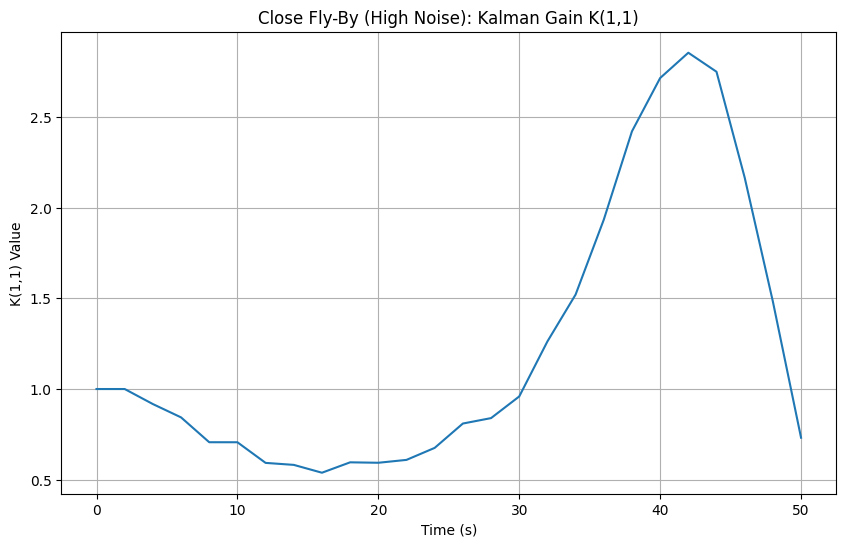

In [113]:
D_m_high, beta_m_high = generate_measurements(D_true_close, beta_true_close, sigma_D_high, sigma_beta_low, N)
x_pseudo_high, y_pseudo_high = to_cartesian(D_m_high, beta_m_high)
z_single_high = np.array([x_pseudo_high, y_pseudo_high]).T

_, _, _, _, K_hist_high, _ = run_kalman_filter(z_single_high, N, Phi, H, X0_0, P0_0, sigma_D_high, sigma_beta_low)

plt.figure(figsize=(10, 6))
plt.plot(time, K_hist_high[:, 0, 0])
plt.title('Close Fly-By (High Noise): Kalman Gain K(1,1)')
plt.xlabel('Time (s)')
plt.ylabel('K(1,1) Value')
plt.grid()
plt.show()

#### Estimation Errors (Close-Range, High Noise)

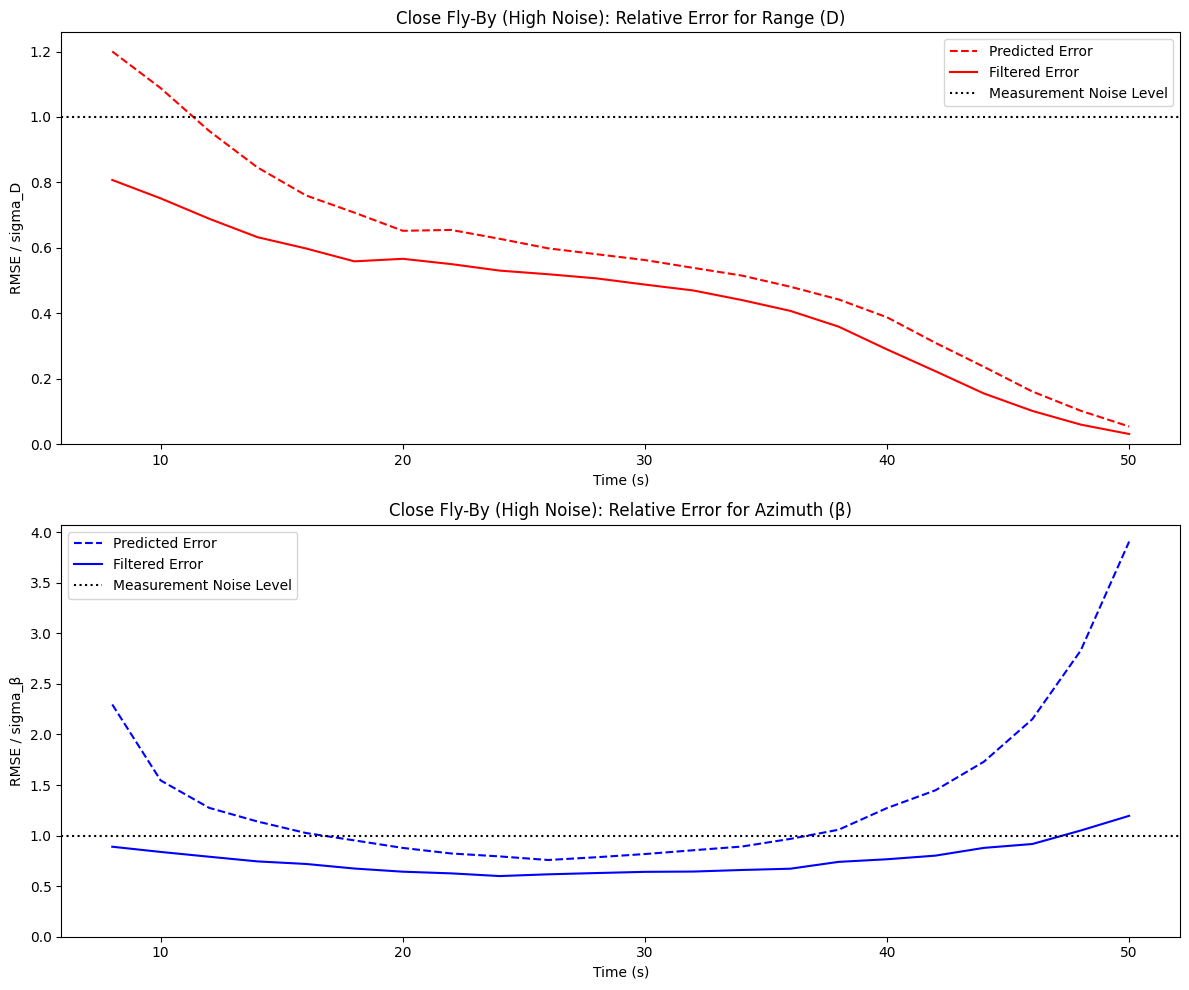

In [123]:
rmse_D_p_high, rmse_D_f_high, rmse_b_p_high, rmse_b_f_high = calculate_errors(
    M, D_true_close, beta_true_close, x_true_close, y_true_close, N, Phi, H, X0_0, P0_0, sigma_D_high, sigma_beta_low
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(time[4:], rmse_D_p_high[4:] / sigma_D_high, 'r--', label='Predicted Error')
ax1.plot(time[4:], rmse_D_f_high[4:] / sigma_D_high, 'r-', label='Filtered Error')
ax1.set_title('Close Fly-By (High Noise): Relative Error for Range (D)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('RMSE / sigma_D')
ax1.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax1.legend()
ax1.set_ylim(bottom=0)

ax2.plot(time[4:], rmse_b_p_high[4:] / sigma_beta_low, 'b--', label='Predicted Error')
ax2.plot(time[4:], rmse_b_f_high[4:] / sigma_beta_low, 'b-', label='Filtered Error')
ax2.set_title('Close Fly-By (High Noise): Relative Error for Azimuth (β)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('RMSE / sigma_β')
ax2.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax2.legend()
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

Filter performance degrades. The azimuth error, in particular, increases around the point of closest approach. This indicates that the filter is diverging, it is amplifying noise instead of reducing it.

#### Dependence of `x` on `β` (Unchanged)

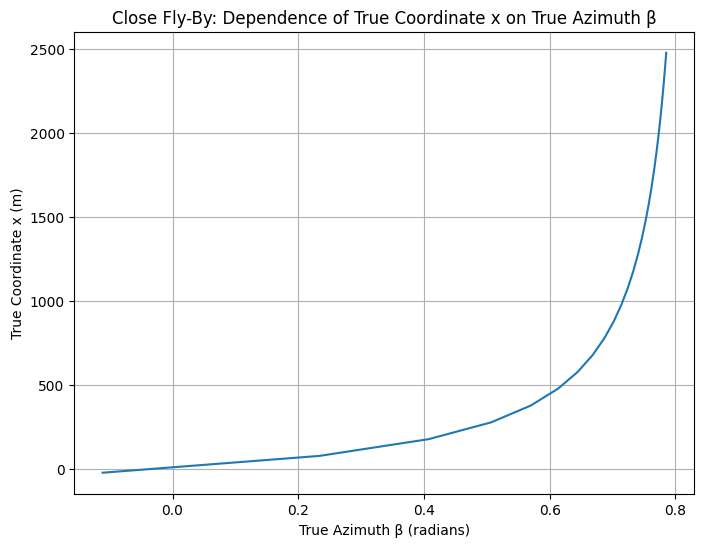

In [118]:
plt.figure(figsize=(8, 6))
plt.plot(beta_true_close, x_true_close)
plt.title('Close Fly-By: Dependence of True Coordinate x on True Azimuth β')
plt.xlabel('True Azimuth β (radians)')
plt.ylabel('True Coordinate x (m)')
plt.grid()
plt.show()

#### Condition Number of R (Close-Range, High Noise)

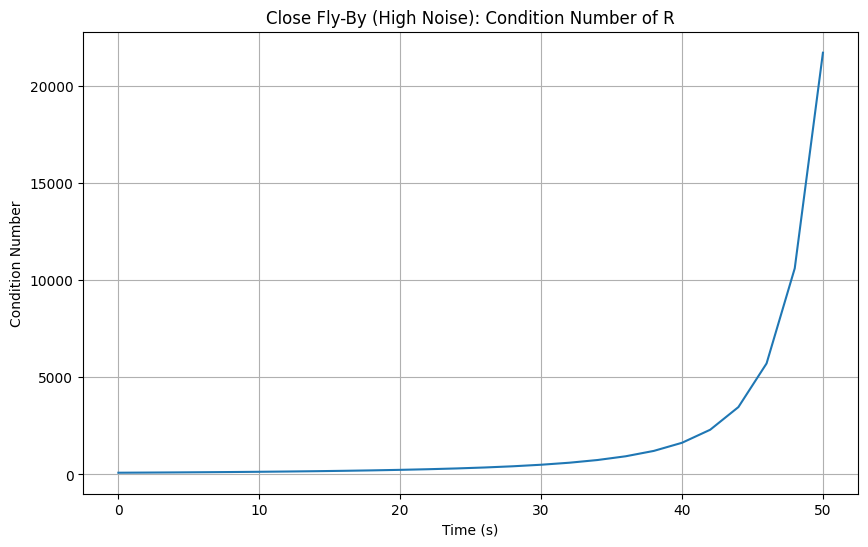

In [119]:
cond_numbers_high = []
for i in range(N):
    R_i = calculate_R(D_true_close[i], beta_true_close[i], sigma_D_high, sigma_beta_low)
    cond_numbers_high.append(np.linalg.cond(R_i))

plt.figure(figsize=(10, 6))
plt.plot(time, cond_numbers_high)
plt.title('Close Fly-By (High Noise): Condition Number of R')
plt.xlabel('Time (s)')
plt.ylabel('Condition Number')
plt.grid()

The condition number is now EXTREMELY high. This indicates a severely ill-conditioned problem. The combination of a large sigma_D and a small sigma_β makes the transformation extremely sensitive to any noise in the range measurement, especially at the point of closest approach.

### 12. Final Conclusions

The navigation system becomes blind and the filter diverges under the combined conditions of:
1.  A close trajectory introduces both significant non-linearity and ill-conditioning.
2.  High uncertainty in range (`sigma_D`) combined with low uncertainty in azimuth (`sigma_β`) dramatically worsens the ill-conditioning of the measurement covariance matrix `R`.

While both linearization errors and ill-conditioning contribute to the filter's failure, the **ill-conditioned problem has the greatest influence**. The extreme spike in the condition number of matrix `R` directly corresponds to the massive spike in estimation error. Linearization errors degrade performance, but the ill-conditioning causes the catastrophic divergence where noise is massively amplified.

#### Solutions to Overcome the Problem:
1. The root cause is the transformation to Cartesian coordinates before filtering, it is better to avoid it, if possible.
2. Use adaptive measurement noise covariance `R`. Potentially down-weighting measurements when the system is in an ill-conditioned state can prevent divergence.
3. Add constraints to the filter gain `K` to prevent it from becoming excessively large during periods of instability.

## 1. Learning Log
